<a href="https://colab.research.google.com/github/JonathanLoscalzo/pytorch-tutorials/blob/master/Deep%20Learning%20with%20Pytorch/01_ConvNets%2C_pooling%2C_dropout%2C_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision

### Gathering data

This data is from some ml-educational course of Google. It is a filtered dataset of kaggle (see cat vs dogs)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O cats_and_dogs_filtered.zip

--2020-05-25 21:36:35--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  77.0MB/s    in 0.9s    

2020-05-25 21:36:36 (77.0 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
!unzip cats_and_dogs_filtered.zip -d ./

Archive:  cats_and_dogs_filtered.zip
   creating: ./cats_and_dogs_filtered/
  inflating: ./cats_and_dogs_filtered/vectorize.py  
   creating: ./cats_and_dogs_filtered/validation/
   creating: ./cats_and_dogs_filtered/train/
   creating: ./cats_and_dogs_filtered/validation/dogs/
  inflating: ./cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: ./cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: ./cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: ./cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: ./cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: ./cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: ./cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: ./cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: ./cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: ./cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: ./cats_and_dogs_fi

In [0]:
import os

In [0]:
if torch.cuda.is_available():
  torch.device('cuda')


# defining directories
base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# transformations to load images. Always we (or pytorch) need ToTensor. 
# Think that images are (h, w, channels) and torch accepts (channels, h, w)
img_size = 64
img_transforms = torchvision.transforms.Compose([
  torchvision.transforms.Resize((img_size,img_size)),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize(
      mean=[0.485, 0.456, 0.406], 
      std=[0.229, 0.224, 0.225] 
  )
])

train_data = torchvision.datasets.ImageFolder(root=train_dir,transform=img_transforms)
val_data = torchvision.datasets.ImageFolder(root=validation_dir, transform=img_transforms)

batch_size=64 # https://pytorch.org/docs/stable/data.html
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)


### Convolutions

In [0]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from random import randint
import numpy as np
import matplotlib.pyplot as plt

#### nn.Conv1d

In [8]:
conv = nn.Conv1d(5,1,1)
stub_input = torch.rand(5).reshape(-1,5,1)
stub_input, conv(stub_input)

(tensor([[[0.5897],
          [0.6311],
          [0.6025],
          [0.1135],
          [0.4755]]]), tensor([[[0.1029]]], grad_fn=<SqueezeBackward1>))

#### nn.Sequential()
This allows us to create a chain of layers. 

When we use one of these chains in forward() , the input goes through each element of the array of layers in succession. 

You can use this to break your model into more logical arrangements

In [9]:
seq = nn.Sequential(nn.Linear(5,2))
seq(torch.rand(5))

tensor([-0.4764,  0.0896], grad_fn=<AddBackward0>)

#### [Convolutional Layer](https://pytorch.org/docs/stable/nn.html#convolution-layers)

In [10]:
from torchvision.utils import make_grid

img_size = 128
img_transforms = torchvision.transforms.Compose([
  torchvision.transforms.Resize((img_size,img_size)),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize(
      mean=[0.485, 0.456, 0.406], 
      std=[0.229, 0.224, 0.225] 
  )
])

img = validation_dir+f'/dogs/dog.{randint(2000,2499)}.jpg'
img = img_transforms(Image.open(img)).unsqueeze(0)
conv_img = nn.Conv2d(3, 64, 5)(img)

conv_img.shape

torch.Size([1, 64, 124, 124])

![](https://peltarion.com/static/2d_convolution_pa3.png)

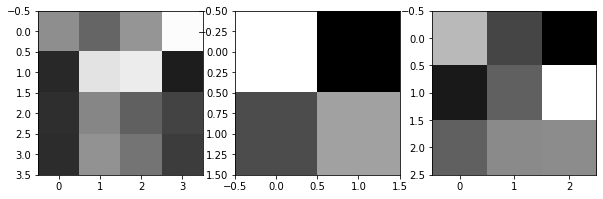

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,10))
sample = torch.randint(0,255,(1,4,4), dtype=torch.float)
ax1.imshow(sample[0], cmap='gray', vmin=0, vmax=255)
# plt.show()

#Next we introduce something called a filter, or convolutional kernel. This is
# another matrix, most likely smaller, which we will drag across our image.
# Here’s our 2 × 2 filter

conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, bias=False)
# in_channels is the number of input channels we’ll be receiving in the layer.
# out_channels is, unsurprisingly, the number of output channels, which corresponds to thenumber of filters in our conv layer
# kernel_size , which describes the height and width of our filter.

res = conv(sample.unsqueeze(0))
ax3.imshow(res[0][0].detach().numpy(), cmap='gray')


ax2.imshow(conv.weight[0][0].detach().numpy(), cmap='gray')

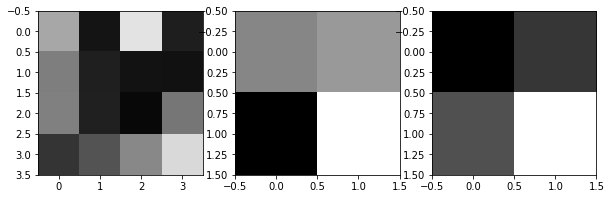

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,10))
sample = torch.randint(0,255,(1,4,4), dtype=torch.float)
ax1.imshow(sample[0], cmap='gray', vmin=0, vmax=255)
# plt.show()

#Next we introduce something called a filter, or convolutional kernel. This is
# another matrix, most likely smaller, which we will drag across our image.
# Here’s our 2 × 2 filter

conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, stride=2, bias=False)
# in_channels is the number of input channels we’ll be receiving in the layer.
# out_channels is, unsurprisingly, the number of output channels, which corresponds to thenumber of filters in our conv layer
# kernel_size , which describes the height and width of our filter.

res = conv(sample.unsqueeze(0))
ax3.imshow(res[0][0].detach().numpy(), cmap='gray')


ax2.imshow(conv.weight[0][0].detach().numpy(), cmap='gray')

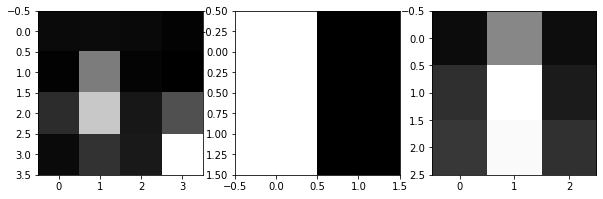

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,10))

sample = torch.tensor(
    [
      [10,11,9,3], 
      [2, 124, 4,0],
      [45,200, 23, 80],
      [10, 50, 25, 255]
    ], dtype=torch.float).reshape(-1,1,4,4)

sample = sample.div(255)

ax1.imshow(sample[0][0], cmap='gray', vmin=0, vmax=1)

conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, bias=False)

conv.weight.data = torch.tensor([[1,0],[1,0]], requires_grad=True, dtype=torch.float).reshape(1,1,2,2)
ax2.imshow(conv.weight.data[0][0], cmap='gray', vmin=0, vmax=1)

res = conv(sample)
ax3.imshow(res[0][0].detach().numpy(), cmap='gray', vmin=0, vmax=1)

### [Pooling](https://pytorch.org/docs/stable/nn.html#pooling-layers)
These layers reduce the resolution of the network from the previous
input layer, which gives us fewer parameters in lower layers.



torch.Size([2, 1, 8, 8])
torch.Size([2, 2, 7, 7]) torch.Size([2, 1, 2, 2])
torch.Size([2, 2, 4, 4])


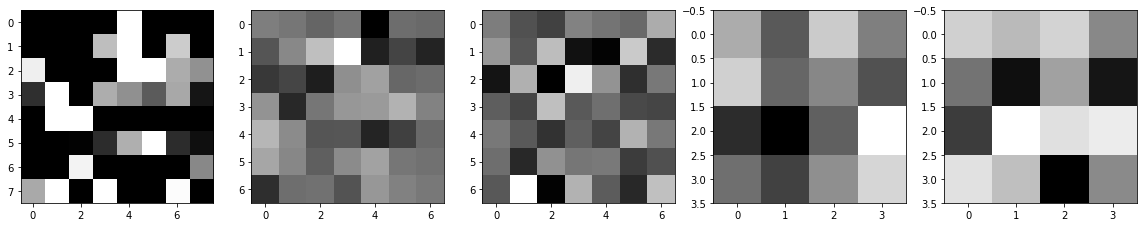

In [51]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(20,5))

sample = torch.randn((2,1,8,8), dtype=torch.float)
ax1.imshow(sample[0][0], cmap='gray', vmin=0, vmax=1)
# plt.show()

#Next we introduce something called a filter, or convolutional kernel. This is
# another matrix, most likely smaller, which we will drag across our image.
# Here’s our 2 × 2 filter
conv = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=2, bias=False)
maxpool = nn.AvgPool2d(kernel_size=4, stride=1)

# in_channels is the number of input channels we’ll be receiving in the layer.
# out_channels is, unsurprisingly, the number of output channels, which corresponds to thenumber of filters in our conv layer
# kernel_size , which describes the height and width of our filter.
print(sample.shape)
res = conv(sample)
print(res.shape, conv.weight.shape)
ax2.imshow(res[0][0].detach().numpy(), cmap='gray')
ax3.imshow(res[0][1].detach().numpy(), cmap='gray')

res = maxpool(res)
ax4.imshow(res[0][0].detach().numpy(), cmap='gray')
ax5.imshow(res[0][1].detach().numpy(), cmap='gray')
print(res.shape)

In [15]:
sample = torch.tensor([[1,2 ,1 ,4 ,1], [5, 6, 1, 2, 5 ], [5, 0, 0, 9, 6]], dtype=torch.float)
maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
maxpool(sample.unsqueeze(0))

tensor([[[6., 9.]]])

### [Dropout](https://pytorch.org/docs/stable/nn.html#dropout)
if we just don’t train a random bunch of nodes within the network
during a training cycle? Because they won’t be updated, they won’t havethe chance to overfit to the input data, and because it’s random, each training cycle will ignore a different selection of the input, which should help generalization even further.

In [16]:
m = nn.Dropout(p=0.5)
inputs = torch.rand((2,2))
output = m(inputs)
print(inputs)
print(output)

tensor([[0.5067, 0.6407],
        [0.1305, 0.1189]])
tensor([[0.0000, 1.2814],
        [0.2610, 0.2378]])


### [BatchNorm](https://pytorch.org/docs/stable/nn.html#normalization-layers)
[Wikipedia](https://en.wikipedia.org/wiki/Batch_normalization)
[d2l](https://d2l.ai/chapter_convolutional-modern/batch-norm.html)

Using two learned parameters (meaning that it will be trained
along with the rest of the network) to try to ensure that each minibatch that goes through the network has a mean centered around zero with a variance of 1.

The BatchNorm layers make sure that even if you use a model such as ResNet-152, the multiplications inside your network don’t get out of hand.

In [25]:
torch.hub.list('pytorch/vision')

Downloading: "https://github.com/pytorch/vision/archive/master.zip" to /root/.cache/torch/hub/master.zip


['alexnet',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'fcn_resnet101',
 'fcn_resnet50',
 'googlenet',
 'inception_v3',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn',
 'wide_resnet101_2',
 'wide_resnet50_2']

In [0]:
class CNNNet(nn.Module):

    def __init__(self, num_classes=2):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1) #or view?
        x = self.classifier(x)
        return x



In [30]:
model = CNNNet(2)
model

CNNNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4)

In [0]:
def train_one_epoch(model, inputs, targets, loss_fn, optimizer):
    optimizer.zero_grad()
    output = model(inputs)
    loss = loss_fn(output, targets)
    loss.backward()
    optimizer.step()
    return loss

def eval_one_epoch(model, inputs, targets, loss_fn):
    output = model(inputs)
    loss_val = loss_fn(output,targets) 
    max_idxs = torch.functional.F.softmax(output, dim=1).argmax(dim=1) # 
    correct = torch.eq(max_idxs, targets)
    return loss_val, correct

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [35]:
epochs=5

for epoch in range(epochs):
  model.train()
  training_loss = 0

  for batch in train_data_loader:
    inputs, targets = batch
    loss = train_one_epoch(model, inputs, targets, loss_fn, optimizer)
    training_loss += loss.item() * inputs.size(0)
  
  training_loss /= len(train_data_loader.dataset)
  model.eval()

  num_correct = 0
  num_examples = 0
  valid_loss = 0

  for batch in val_data_loader:
    inputs, targets = batch
    loss_val, correct = eval_one_epoch(model, inputs, targets, loss_fn)
    valid_loss += loss_val.data.item() * inputs.size(0)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]

  valid_loss /= len(val_data_loader.dataset)

  print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(
      epoch, 
      training_loss, 
      valid_loss, 
      num_correct / num_examples
  ))



Epoch: 0, Training Loss: 0.80, Validation Loss: 0.69, accuracy = 0.50
Epoch: 1, Training Loss: 0.70, Validation Loss: 0.69, accuracy = 0.56
Epoch: 2, Training Loss: 0.69, Validation Loss: 0.68, accuracy = 0.60
Epoch: 3, Training Loss: 0.69, Validation Loss: 0.69, accuracy = 0.53
Epoch: 4, Training Loss: 0.68, Validation Loss: 0.69, accuracy = 0.50


### Inference

/usr/local/lib/python3.6/dist-packages/toolz/functoolz.py:634: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  data = func(data)


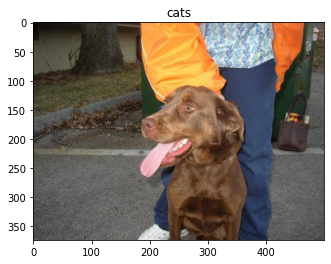

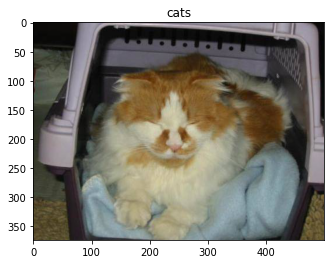

In [46]:
from toolz import pipe
from functools import partial
from PIL import Image, ImageFile
from random import randint

labels = list(train_data.class_to_idx.keys())

model.eval()

to_evaluate = [validation_dir+f'/dogs/dog.{randint(2000,2499)}.jpg', validation_dir+f"/cats/cat.{randint(2000,2499)}.jpg"]

for ix, file in enumerate(to_evaluate):
  img = Image.open(file) 
  prediction = pipe(
      img, 
      img_transforms,
      partial(torch.reshape, shape=(-1,3,128,128)),
      model,
      torch.functional.F.softmax
  )
  prediction = prediction.argmax()
  plt.figure()
  plt.imshow(img)
  plt.title(labels[prediction])